# dog vs. cat classification. ResNet 실습하기

## 환경설정

### tensorflw 버전 업그레이드

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 501kB 52.9MB/s 
     |████████████████████████████████| 4.3MB 40.5MB/s 


In [ ]:
# for gpu
$pip install --upgrade tensorflow-gpu

### 압축 풀기

In [ ]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('/content/drive/My Drive/compete/boaz-cs231n-final.zip')
fantasy_zip.extractall('/content/drive/My Drive/compete')
 
fantasy_zip.close()

### Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 64
img_width = 224
img_height = 224

def image_data_generator(train_dir,
                       data_augment=False,
                       batch_size=64,
                       target_size=(img_width, img_height),
                       color_mode='rgb',
                       class_mode='binary',
                       shuffle=True):
  if data_augment:   # train set generator -> augmentation O
      datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rescale=1./255,               # 픽셀 값 변환
                                   rotation_range=45,            # 45도까지 회전
                                   width_shift_range=0.2,        # 좌우로 이동
                                   height_shift_range=0.2,       # 위아래로 이동
                                   shear_range=0.2,              # 20도까지 기울임       
                                   zoom_range=0.2,               # 20%까지 확대
                                   horizontal_flip=True,         # 좌우로 뒤집기
                                   vertical_flip=True)           # 위아래로 뒤집기
      
      
  else:            # validation set data generator -> augmentation X
      datagen = ImageDataGenerator(rescale=1./255)               # validation set에는 augmentation X

  generator = datagen.flow_from_directory(train_dir,
                                          target_size=target_size,
                                          color_mode=color_mode,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          class_mode=class_mode)
  return generator


train = image_data_generator('/content/drive/My Drive/compete/training_set', data_augment=True)
valid = image_data_generator('/content/drive/My Drive/compete/valid_set', data_augment=False)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


0.0


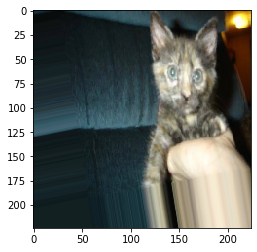

In [ ]:
import matplotlib.pyplot as plt
for X_batch, Y_batch in train:
    image = X_batch[0]
    plt.imshow(image)
    print(Y_batch[0])  #0 (고양이) 또는 1 (강아지)  ->  binary classification
    break

## Resnet

In [ ]:
#미리 학습되어 있는 ResNet 모형 불러오기
from tensorflow.keras.applications import ResNet50V2
resnet = ResNet50V2()
resnet.summary()

102875136/102869336 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________

In [ ]:
#ResNet 모형 상단의 softmax 레이어를 제거
resnet = ResNet50V2(include_top=False)  # weights 디폴트는 imagenet으로 학습

94674944/94668760 [==============================] - 3s 0us/step


In [ ]:
#resnet이 더이상 학습되지 않도록 모든 파라미터 고정
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
#resnet의 출력을 Dense 레이어의 입력으로 받아서 fc의 출력으로 이어지는 모형

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# flatten
x = GlobalAveragePooling2D()(resnet.output)
# hidden layers
x = Dense(256, activation='relu')(x)
# dropout rate
x = Dropout(0.1)(x)
#output
fc = Dense(1, activation = 'sigmoid')(x)

In [ ]:
#모형 구축

from tensorflow.keras.models import Model

model = Model(inputs=resnet.input, outputs=fc)

In [ ]:
model.summary() #마지막 레이어에 FC가 추가된 것을 확인

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

**전이학습(Transfer Learning) : 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것**

먼저 Imagenet으로 이미 학습된 resnet 신경망을 불러오고, 이 신경망의 가중치가 학습되지 않도록 레이어들을 동결시킨다.

그리고 입력 데이터 수와 분류 개수에 대한 Fully Connected Dense layer를 생성하여 resnet 신경망을 구성하는 마지막 레이어 대신에 교체한다.

결과적으로 이 신경망의 마지막 레이어를 제외한 특징 추출 레이어들은 학습되지 않고, 마지막 레이어만을 학습된다.

## Model Building

In [ ]:
#얼리스타핑

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
# 체크포인트

from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [ ]:
#from tensorflow.keras.optimizers import SGD       
from tensorflow.keras.optimizers import Adam      

model.compile(optimizer='adadelta',    
#    optimizer=Adam(lr=1e-4),            
#    optimizer=SGD(lr=1e-4),                     
    loss='binary_crossentropy',
    metrics=['acc']
)

### 모델 학습

In [ ]:
epochs = 10

history = model.fit_generator(
    train, 
    epochs=epochs,
    steps_per_epoch=train.samples // batch_size, 
    validation_data=valid,
    validation_steps=valid.samples // batch_size,
    callbacks=[es,best_model],
    use_multiprocessing=True,
    workers=0     #User warning - Input could not be retrived 해결
)

### best 모델 저장

In [ ]:
from keras.models import load_model

model.save('resnet50V2_model.h5')

Using TensorFlow backend.


### 모델 학습 결과

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


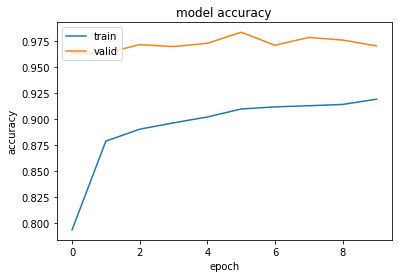

In [ ]:
import matplotlib.pyplot as pl

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

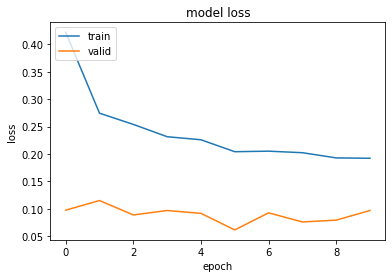

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### best 모델 불러오기

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/resnet50V2_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Submission

In [ ]:
import pandas as pd
import os

test_filenames = os.listdir("/content/drive/My Drive/compete/test_set/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
IMAGE_SIZE = (224,224)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/My Drive/compete/test_set/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2000 validated image filenames.


In [ ]:
import numpy as np
predict = new_model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
predict

array([[0.        ],
       [0.        ],
       [0.9999996 ],
       ...,
       [0.13192174],
       [1.        ],
       [0.        ]], dtype=float32)

In [ ]:
threshold = 0.5

#test_df['category'] = np.where(predict > threshold, 1,0)
test_df['category'] = np.where(predict > threshold, 0,1)

In [ ]:
test_df

,filename,category2,category
0,7567.jpg,1,1
1,9825.jpg,1,1
2,8017.jpg,0,0
3,7539.jpg,1,1
4,7308.jpg,1,1
...,...,...,...
1995,2848.jpg,1,1
1996,3242.jpg,1,1
1997,1765.jpg,1,0
1998,3156.jpg,0,0


In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['category'] = submission_df['category']
submission_df.drop(['filename'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)